# Gearbox

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
s1, s2, s3, s4 = ?

while(t < T):

    v = update_v

    if gear == 1 and v >= s1 {
        gear = 0, nxt = 2, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif w < 0 and gear == 0 {
        gear = nxt;
    }

    w = w - 0.1;
```

Velocity evolves according to:
$$ \frac{d \textit{v}}{dt} = \begin{cases} v \cdot \alpha(i, v) + \textit{gauss}(5., 1.) & \text{if gear==i} \\
                                        -0.0005 v^2 + \textit{gauss}(0., 0.5) & \text{if gear==0}  \end{cases} $$

where $\alpha(i,v) = \frac{1}{1 + \frac{(v-p_i)^2}{25}}$ and $p_i = (5, 15, 25, 40, 60)$.

In [5]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
import matplotlib.pyplot as plt
from time import time

torch.set_default_dtype(torch.float64)

### Original Model

In [6]:
# Cerchiamo un'approssimazione ragionevole per alpha

#import matplotlib.pyplot as plt
#
#lb = [0, 10, 20, 30, 50]
#ub = [10, 20, 30, 50, 100]
#p = [5,15, 25, 40, 60]
#
#for i in range(5):
#    v = np.linspace(lb[i], ub[i], 100)
#    y = [1/(1+(vi - p[i])**2/25) for vi in v]
#    
#    print('Average alpha {}: '.format(i+1), np.mean(y))

In [7]:
def orig_model(T=20, init_v=5., gear=1, s1=10, s2=20):
    
    traj = torch.zeros(T)
    traj[0] = init_v
    #noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))

    w = 0.
    p = [5, 15, 25, 40, 60]
    s = [s1, s2]
    alpha = [0.78, 0.78, 0.78, 0.55, 0.25]
    
    for i in range(1,T):
        
        #update velocity
        if gear >= 1:
            traj[i] = traj[i-1] + 0.1*traj[i-1]*alpha[gear-1] + 0.1*distributions.Normal(5., 1.).rsample() 
        else:
            traj[i] = traj[i-1] - 0.1*0.0005*traj[i-1]**2 + distributions.Normal(0., 1.).rsample() 

        # update gear
        if gear >= 1 and gear < 3 and traj[i] > s[gear-1]:
            nxt = gear + 1
            gear = 0
            w = 0.3
        elif gear == 0 and w < 0:
            gear = nxt

        w = w - 0.1            
            
    return traj        

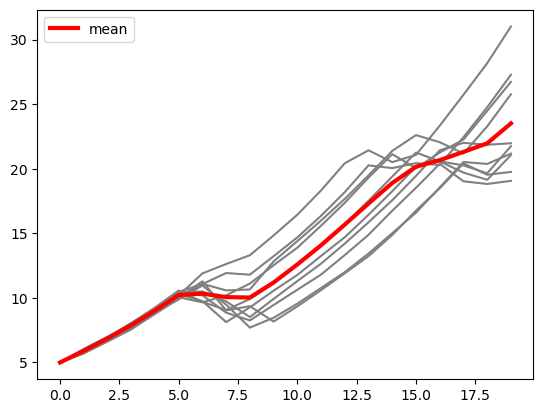

In [8]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
for _ in range(50):
    traj_set.append(orig_model())
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(20), traj_set[i], color='grey')

plt.plot(range(20), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

### MCMC Optimization

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS
import torch

def pyro_gearbox_model(observed_traj, T=20, init_v=5.):
    # Priors for s1 and s2
    s1 = pyro.sample("s1", dist.Normal(7.0, 1.0))
    s2 = pyro.sample("s2", dist.Normal(25.0, 1.0))

    batch_size = observed_traj.shape[0]
    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_v

    w = torch.zeros(batch_size)
    gear = torch.ones(batch_size, dtype=torch.long)
    nxt = torch.zeros(batch_size, dtype=torch.long)
    p = [5, 15, 25, 40, 60]
    alpha = [0.78, 0.78, 0.78, 0.55, 0.25]
    s = torch.stack([s1.expand(batch_size), s2.expand(batch_size)], dim=1)

    for i in range(1, T):
        # update velocity
        mask_gear = gear >= 1
        
        traj[mask_gear, i] = traj[mask_gear, i-1] + 0.1 * traj[mask_gear, i-1] * torch.tensor(alpha)[gear[mask_gear]-1] + 0.1 * dist.Normal(5., 1.).sample([mask_gear.sum()])
        traj[~mask_gear, i] = traj[~mask_gear, i-1] - 0.1 * 0.0005 * traj[~mask_gear, i-1]**2 + dist.Normal(0., 1.).sample([(~mask_gear).sum()])

        # update gear
        for b in range(batch_size):
            if gear[b] >= 1 and gear[b] < 3 and traj[b, i] > s[b, gear[b]-1]:
                nxt[b] = gear[b] + 1
                gear[b] = 0
                w[b] = 0.3
            elif gear[b] == 0 and w[b] < 0:
                gear[b] = nxt[b]
            w[b] = w[b] - 0.1

    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Normal(traj, 1.0).to_event(1), obs=observed_traj)

In [14]:
# Run HMC   
hmc_kernel = HMC(pyro_gearbox_model)              # painfully slow (1 min for 7 samples)
mcmc = MCMC(hmc_kernel, num_samples=200, warmup_steps=100, num_chains=1)
mcmc.run(traj_set)

posterior_samples = mcmc.get_samples()
print("Posterior mean s1:", posterior_samples["s1"].mean().item())
print("Posterior mean s2:", posterior_samples["s2"].mean().item())

Warmup:   2%|▏         | 7/300 [00:08,  1.74s/it, step size=1.22e-02, acc. prob=0.429]

KeyboardInterrupt: 

In [16]:
# Run NUTS
nuts_kernel = NUTS(pyro_gearbox_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)     # 0 acceptance probability
mcmc.run(traj_set)

posterior_samples = mcmc.get_samples()
print("Posterior mean s1:", posterior_samples["s1"].mean().item())
print("Posterior mean s2:", posterior_samples["s2"].mean().item())

Sample:  49%|████▊     | 728/1500 [02:44,  6.35it/s, step size=6.53e-42, acc. prob=0.000] 

KeyboardInterrupt: 

### VI Optimization

In [65]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import torch

# Pyro model for VI
def pyro_gearbox_model_vi(observed_traj, T=20, init_v=5.):
    
    s1 = pyro.sample("s1", dist.Normal(7.0, 1.0))
    s2 = pyro.sample("s2", dist.Normal(25.0, 1.0))

    batch_size = observed_traj.shape[0]
    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_v

    w = torch.zeros(batch_size)
    gear = torch.ones(batch_size, dtype=torch.long)
    nxt = torch.zeros(batch_size, dtype=torch.long)
    p = [5, 15, 25, 40, 60]
    alpha = [0.78, 0.78, 0.78, 0.55, 0.25]
    s = torch.stack([s1.expand(batch_size), s2.expand(batch_size)], dim=1)

    for i in range(1, T):
        mask_gear = gear >= 1
        traj[mask_gear, i] = traj[mask_gear, i-1] + 0.1 * traj[mask_gear, i-1] * torch.tensor(alpha)[gear[mask_gear]-1] + 0.1 * dist.Normal(5., 1.).rsample([mask_gear.sum()])
        traj[~mask_gear, i] = traj[~mask_gear, i-1] - 0.1 * 0.0005 * traj[~mask_gear, i-1]**2 + dist.Normal(0., 1.).rsample([(~mask_gear).sum()])

        for b in range(batch_size):
            if gear[b] >= 1 and gear[b] < 3 and traj[b, i] > s[b, gear[b]-1]:
                nxt[b] = gear[b] + 1
                gear[b] = 0
                w[b] = 0.3
            elif gear[b] == 0 and w[b] < 0:
                gear[b] = nxt[b]
            w[b] = w[b] - 0.1

    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Normal(traj, 1.0).to_event(1), obs=observed_traj)

# Guide (mean-field)
def guide(observed_traj, T=20, init_v=5.):
    s1_loc = pyro.param("s1_loc", torch.tensor(7.0))
    #s1_scale = pyro.param("s1_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    s2_loc = pyro.param("s2_loc", torch.tensor(25.0))
    #s2_scale = pyro.param("s2_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    pyro.sample("s1", dist.Normal(s1_loc, torch.tensor(1.0)))
    pyro.sample("s2", dist.Normal(s2_loc, torch.tensor(1.0)))

# SVI setup
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.001})
svi = SVI(pyro_gearbox_model_vi, guide, optimizer, loss=Trace_ELBO())

loss_list = []
step_list = []

start = time()

num_steps = 1000


for step in range(num_steps):
    loss = svi.step(traj_set)
    if step % 100 == 0:
        print(f"Step {step} - Loss: {loss}")
        loss_list.append(loss)
        step_list.append(step)

end = time()

print(f"Optimization performed in {end - start:.2f} seconds")

# Extract optimized parameters
vi_s1 = pyro.param("s1_loc").item()
vi_s2 = pyro.param("s2_loc").item()
print(f"Optimized s1: {vi_s1:.2f}, s2: {vi_s2:.2f}")

c:\Users\birik\anaconda3\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'s1', 's2'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Step 0 - Loss: 5763.227969766002


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

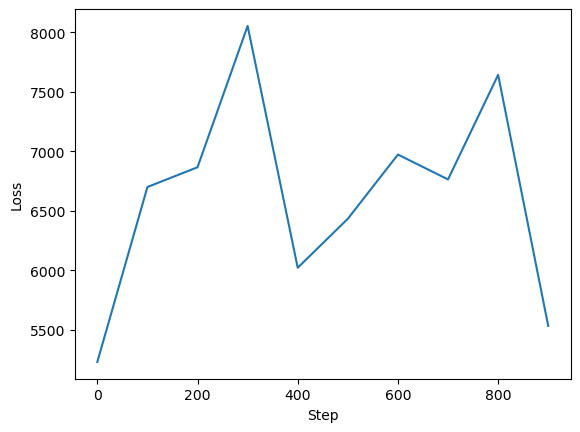

In [61]:
plt.plot(step_list, loss_list)
plt.xlabel("Step")
plt.ylabel("Loss")

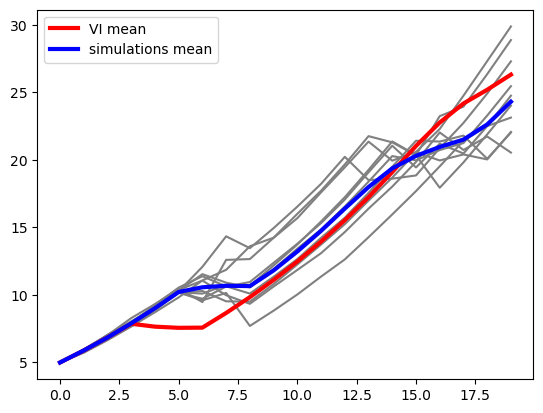

In [58]:
# Trajectories generated using the optimized parameters

vi_traj_set = []
for _ in range(100):
    vi_traj_set.append(orig_model(s1 = vi_s1, s2 = vi_s2))
vi_traj_set = torch.vstack(vi_traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(20), traj_set[i], color='grey')

plt.plot(range(20), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')
plt.plot(range(20), torch.mean(traj_set, 0), lw=3, color='blue', label='simulations mean')

plt.legend()

### SOGA program

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

pars = {'s1':7., 's2':25.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

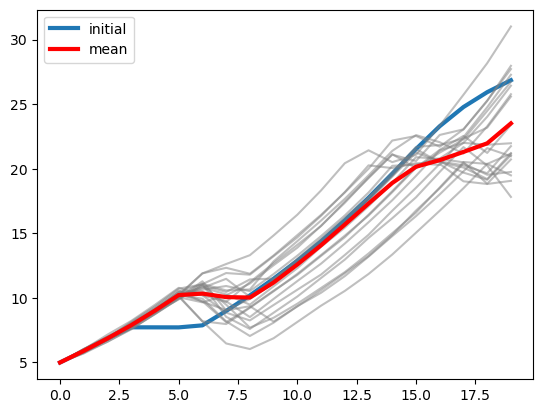

In [12]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:20].detach()
plt.plot(range(20), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(20):
    plt.plot(range(20), traj_set[i], color='grey', alpha=0.5)

plt.plot(range(20), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [13]:
def neg_log_likelihood(traj_set, dist):
    idx = list(range(1,20))
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = list(range(1,20))
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)

tensor(2112.8333, grad_fn=<NegBackward0>)

In [47]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

start = time()

for i in range(200):
    
    optimizer.zero_grad()  # Reset gradients
    
    #with torch.autograd.set_detect_anomaly(True):
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_log_likelihood(traj_set, current_dist)
        
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 20 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

end=time()

print('Optimization performed in ', round(end-start, 3))

# Before optimizing the code the optimization was performed in  1708.269 s

s1: 7.049999999998867 s2: 24.950000000002404  loss: 2132.9705133649068
s1: 8.016085679772388 s2: 23.958783580495023  loss: 1451.8821547399775
s1: 8.688379975962476 s2: 23.038826191457414  loss: 1140.7401150289934
s1: 9.305409947674919 s2: 22.204643884511523  loss: 910.2792263902438
s1: 9.519004990445492 s2: 21.486488862878513  loss: 830.8028180589322
s1: 9.614938761267547 s2: 20.89888649193309  loss: 784.2750441690612
s1: 9.717374951324096 s2: 20.447465163570374  loss: 758.1355404703083
s1: 9.841398943805459 s2: 20.13943161303503  loss: 745.1718745067587
s1: 9.930357069433498 s2: 19.96220774964912  loss: 741.220024545057
s1: 9.9509716989904 s2: 19.88110565115265  loss: 740.7464138173863
Optimization performed in  574.342


In [48]:
params_dict

{'s1': tensor(9.9436, requires_grad=True),
 's2': tensor(19.8535, requires_grad=True)}

In [50]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Gearbox.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)

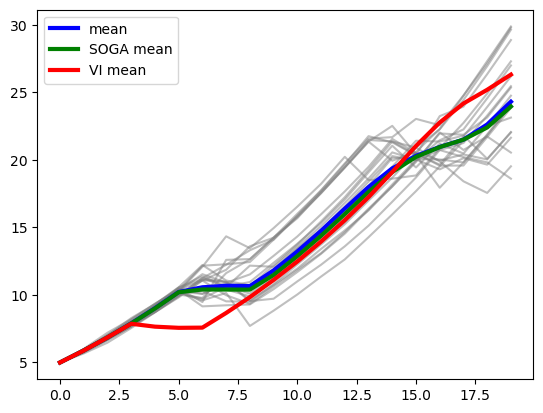

In [59]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(20):
    plt.plot(range(20), traj_set[i], color='grey', alpha=0.5)

plt.plot(range(20), torch.mean(traj_set, 0), lw=3, color='blue', label='mean')

#plt.plot(range(20), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(20), output_dist.gm.mean()[:20].detach(), lw=3, color='green', label='SOGA mean')

plt.plot(range(20), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')

plt.legend()